# Доверительные интервалы

In [1]:
import matplotlib.pyplot as plt
from scipy.stats import gamma, norm, uniform
from functools import reduce
import numpy as np
import matplotlib
matplotlib.rc('font', size=22)
matplotlib.rc('animation', html='html5')
bigfontsize=20
labelfontsize=16
tickfontsize=16
plt.rcParams.update({'font.size': bigfontsize,
                     'axes.labelsize':labelfontsize,
                     'xtick.labelsize':tickfontsize,
                     'ytick.labelsize':tickfontsize,
                     'legend.fontsize':tickfontsize,
                     })




Доверительным интервалом с уровнем доверия $100\times(1-\alpha)\%$ параметра $\theta$ называется интервал значений параметра $(l,u)$ который содержит $100\times(1-\alpha)\%$ распределения апостериорной плотности вероятности:

$$ C_{\alpha}(\mathcal{D}) = (l,u): P(l\leq\theta\leq u|\mathcal{D}) = 1 - \alpha $$

Другими словами, "истинное значение" параметра $\theta$ находится в этом интервале с вероятностью $100\times(1-\alpha)\%$ (понимая всю условность термина "истинное значение параметра" в контексте байесовкой статистики.

Рассмотрим несколько примеров.

In [90]:
def discretize(pdf, plot_range, nsteps):
    dx = (plot_range[1]-plot_range[0])/nsteps
    x = np.linspace(*plot_range, nsteps)
    if type(pdf)!=dict:
        pdf_v = pdf.pdf(x)
    else:
        pdf_v = np.sum([v*k.pdf(x) for k, v in pdf.items()], axis = 0)
    return pdf_v, x, dx


    
def plot_interval(pdf, cl, interval_type, plot_range = [-5, 5], nsteps = 100):
    """
    pdf - pdf of a parameter
    cl - credibility level (0-100)
    interval_type - could be "central", "HDI","UL","LL"
    plot_range - interval for the plot
    nsteps - number grid step for numeric integration of the PDF
    """
    
    pdf_v, x, dx = discretize(pdf, plot_range, nsteps)
    
    if interval_type == "LL":
        # Upper limit is max of support
        u = plot_range[-1]
        # Finding lowe limit
        l = x[0]
        integral = 0
        for i in range(nsteps):
            integral += pdf_v[-1-i]*dx
            if integral >=cl/100:
                l = x[-i]
                break
        mask  = x >= l
        
    if interval_type == "UL":
        l = x[0]
        u = x[-1]
        integral = 0
        for i in range(nsteps):
            integral += pdf_v[i]*dx
            if integral >=cl/100:
                u = x[i-1]
                break
        mask = x<=u

    if interval_type == "central":
        integral = 0
        for i in range(nsteps):
            integral += pdf_v[i]*dx
            if integral >=(1-cl/100)/2:
                l = x[i-1]
                break
        integral = 0
        for i in range(nsteps):
            integral += pdf_v[i]*dx                
            if integral >= 1-(1-cl/100)/2:
                u = x[i-1]  
                break
        mask = ((x>=l)&(x<=u))
    
    if interval_type == "HDI":
        sorted_pdf = np.sort(pdf_v)[::-1]
        integral = 0
        y_vals = []
        i_max = 0
        for i in range(nsteps):
            integral += sorted_pdf[i]*dx
            if integral >= cl/100:
                i_max = i-1
                break
        mask = np.in1d(pdf_v, sorted_pdf[:i_max])
        
    f = plt.figure(figsize = (10,10))
    plt.plot(x, pdf_v, color = "black")
    plt.fill_between(x, 0, pdf_v, where = mask, color = "gray", alpha = 0.2, label = str(cl)+"% CL")
    plt.legend()
    return f
    
    

## Верхний предел

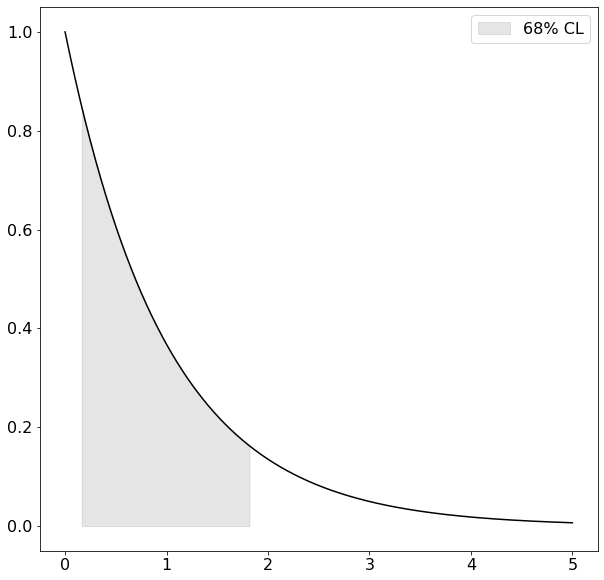

In [120]:
from scipy.stats import expon
f = plot_interval(expon, 68, "central", plot_range = [0, 5], nsteps = 1000)

## Нижний предел

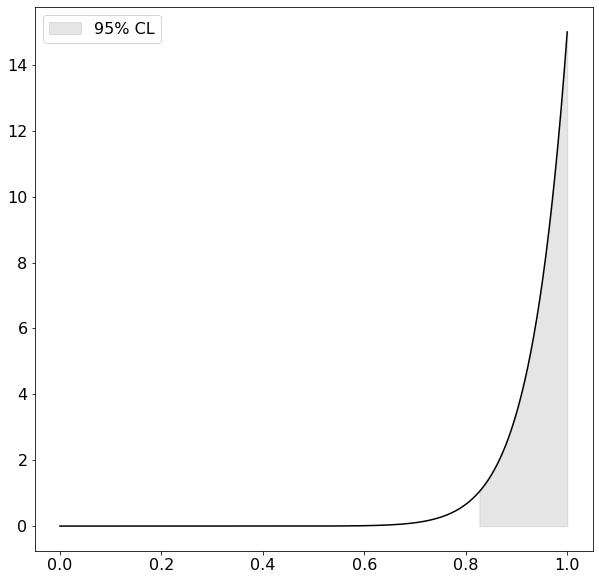

In [112]:
from scipy.stats import beta
f = plot_interval(beta(15,1), 95, "LL", plot_range = [0, 1], nsteps = 1000)

## Центральный интервал

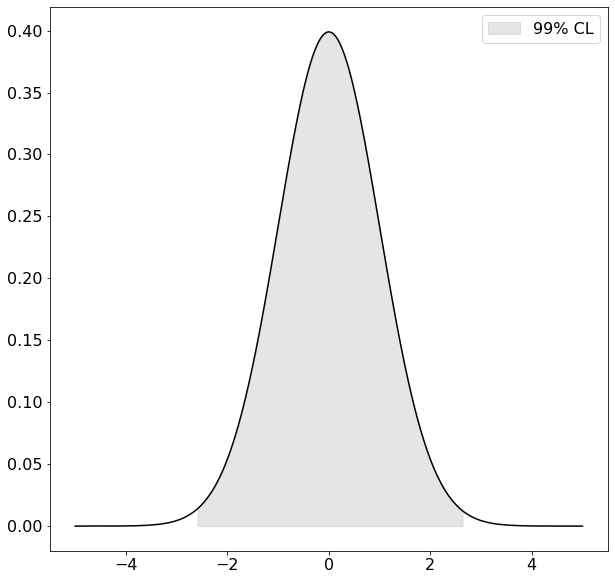

In [118]:
from scipy.stats import norm
f = plot_interval(norm(0,1), 99, "central", plot_range = [-5, 5], nsteps = 1000)

## Наименьший интервал

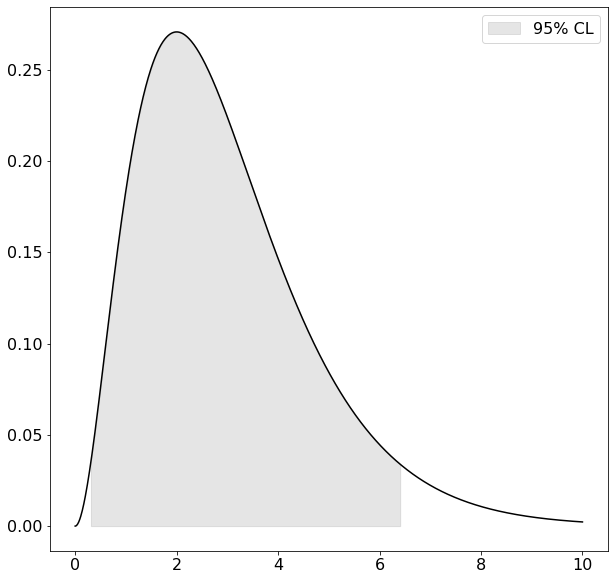

In [105]:
from scipy.stats import gamma
f = plot_interval(gamma(3), 95, "HDI", plot_range = [0, 10], nsteps = 1000)

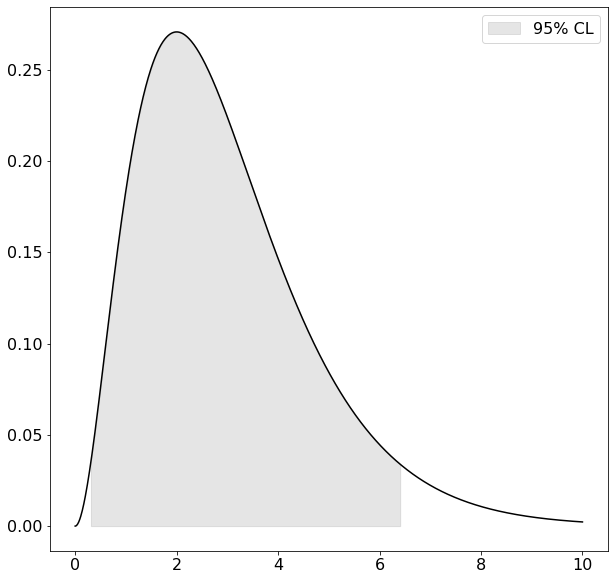

In [119]:
from scipy.stats import gamma
f = plot_interval(gamma(3), 95, "HDI", plot_range = [0, 10], nsteps = 1000)

## Разделенные интервалы

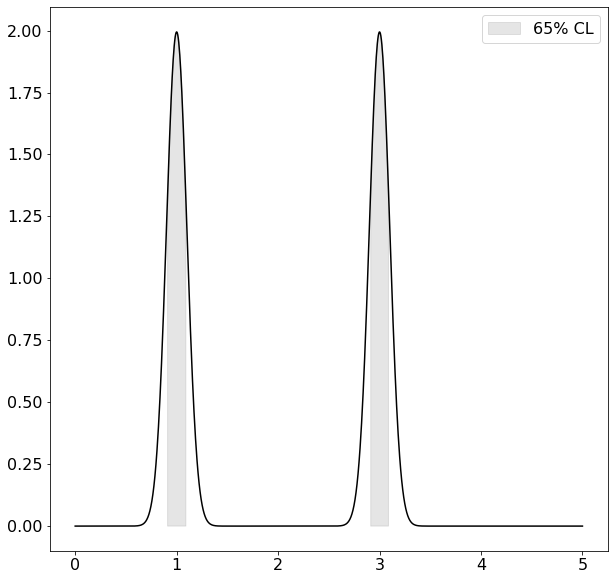

In [121]:
from scipy.stats import norm
f = plot_interval({norm(3,0.1):0.5, norm(1,0.1):0.5}, 65, "HDI", plot_range = [0, 5], nsteps = 1000)

# Интервалы в классической статистике

Для построения доверительного интервала в классической статистике нужно сперва определиться со способом определения возможных  значений параметра $\theta$. При повторении экспериментов этот способ оценки будет давать разные интервалы. Уровнем доверия интервал полученного в ходе эксперимента является доля интервалов опредленных тем же способом в псевдо экспериентах содержащих истинное значение параметра $\theta$.

Одним из способов построения таких интервалов был предложен Нейманом.

Ниже приведен пример построения доверитеьного интервала оценки среднего значения нормально расрпеделенной случайной величины используя ограниченную выборку.

In [69]:
(np.sum((data-mu_likelihood)**2)/exp_size)**0.5

1.3668841839411268

In [70]:
norm(mu_likelihood, sigma_likelihood**0.5).ppf((1-cl)/2)

-2.6668655470090203

Text(0, 0.5, 'Значение параметра')

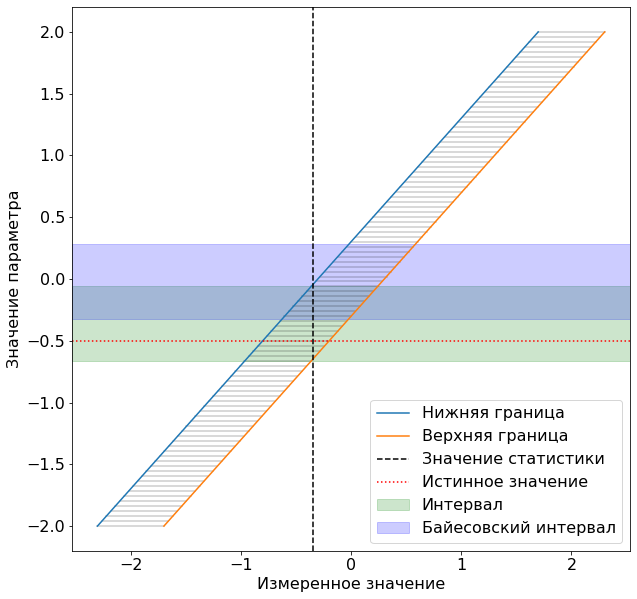

In [77]:
from scipy.stats import norm
true_mu = -0.5
true_sigma = 1
cl = 0.5
exp_size = 5 # Набор данных состоит из 10 значений

data = norm(true_mu,true_sigma).rvs(exp_size)

x = np.linspace(-10,10, 100)
mus = np.linspace(-2, 2, 100)
# Мы знаем форму распределения значений оценки из формы сигнала. 
# При большом количестве точек в данных, однако, мы все равно можем считать 
# распределение оценки нормальным.
lower_l = [norm(i_mu, true_sigma/exp_size**0.5).ppf((1-cl)/2) for i_mu in mus]
upper_l = [norm(i_mu, true_sigma/exp_size**0.5).ppf(1-(1-cl)/2) for i_mu in mus]

ll = mus[np.argmin(np.abs(lower_l-data.mean()))]
ul = mus[np.argmin(np.abs(upper_l-data.mean()))]

# Байесовский интервал
# Априорно мы считаем что значение распеределено с N(1,1)
# Формулы из Мерфи, стр 137
prior_mu = 1
prior_sigma = 1
sigma_likelihood = 1/(exp_size/true_sigma**2+1/prior_sigma**2)
mu_likelihood = sigma_likelihood**2*(prior_mu/prior_sigma**2+exp_size*data.mean()/true_sigma**2)
sigma_likelihood = true_sigma/exp_size**0.5
b_ll = norm(mu_likelihood, sigma_likelihood).ppf((1-cl)/2)
b_ul = norm(mu_likelihood, sigma_likelihood).ppf(1-(1-cl)/2)                                                 

# Строим график
intervals = list(zip(lower_l,upper_l))

f = plt.figure(figsize = (10,10))
for num, i in enumerate(intervals):
    plt.plot(i, (mus[num],mus[num]),c = "black", alpha = 0.2)
plt.plot(lower_l,mus, label = "Нижняя граница")
plt.plot(upper_l,mus, label = "Верхняя граница")
plt.axvline(data.mean(), color = "black", ls = "--", label = "Значение статистики")
plt.axhline(true_mu, color = "red", ls = ":", label = "Истинное значение")
# plt.fill_between([x[0],x[-1]],[ll,ll],[ul,ul],color='green')
plt.axhspan(ll,ul, color = "green", alpha = 0.2,label = "Интервал")
plt.axhspan(b_ll,b_ul, color = "blue", alpha = 0.2,label = "Байесовский интервал")
# plt.axhline(ul, color = "green", ls = "-")
plt.legend()
plt.xlabel("Измеренное значение")
plt.ylabel("Значение параметра")
